In [1]:
# Create spark version
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.3.1'
spark_version = 'spark-3.3.2'
os.environ['SPARK_VERSION']=spark_version

In [2]:
# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:5 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:6 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:9 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:10 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3,255 kB]
Hit:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:12 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Get:13 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1,354 kB]
Fetched 4,945 kB in 3s (1,44

In [3]:
# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

In [4]:
# Import findspark and initialize. 
import findspark
findspark.init()

In [5]:
# Start Spark session
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, countDistinct
spark = SparkSession.builder.appName("ObesityRiskFactors").getOrCreate()

In [6]:
# Read CSV from google drive
behavioral_risk_df = spark.read.csv('Nutrition__Physical_Activity__and_Obesity_-_Behavioral_Risk_Factor_Surveillance_System.csv', header=True, inferSchema = True)


In [7]:
# Show data columns and types
behavioral_risk_df.printSchema()

root
 |-- YearStart: integer (nullable = true)
 |-- YearEnd: integer (nullable = true)
 |-- LocationAbbr: string (nullable = true)
 |-- LocationDesc: string (nullable = true)
 |-- Datasource: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Topic: string (nullable = true)
 |-- Question: string (nullable = true)
 |-- Data_Value_Unit: string (nullable = true)
 |-- Data_Value_Type: string (nullable = true)
 |-- Data_Value: double (nullable = true)
 |-- Data_Value_Alt: double (nullable = true)
 |-- Data_Value_Footnote_Symbol: string (nullable = true)
 |-- Data_Value_Footnote: string (nullable = true)
 |-- Low_Confidence_Limit: double (nullable = true)
 |-- High_Confidence_Limit : double (nullable = true)
 |-- Sample_Size: integer (nullable = true)
 |-- Total: string (nullable = true)
 |-- Age(years): string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Income: string (nullable = true)
 |-- Race/Ethnicity: string (nul

In [8]:
# Show unique Year values
behavioral_risk_df.select("YearStart","YearEnd").distinct().collect()

[Row(YearStart=2015, YearEnd=2015),
 Row(YearStart=2014, YearEnd=2014),
 Row(YearStart=2020, YearEnd=2020),
 Row(YearStart=2019, YearEnd=2019),
 Row(YearStart=2012, YearEnd=2012),
 Row(YearStart=2016, YearEnd=2016),
 Row(YearStart=2011, YearEnd=2011),
 Row(YearStart=2013, YearEnd=2013),
 Row(YearStart=2018, YearEnd=2018),
 Row(YearStart=2017, YearEnd=2017),
 Row(YearStart=2021, YearEnd=2021)]

In [9]:
# Remove unwanted columns
behavioral_risk_df = behavioral_risk_df.drop(*('YearEnd', 'LocationAbbr', 'Datasource',
       'Class', 'Topic', 'Data_Value_Unit', 'Data_Value_Type',
       'Data_Value_Alt', 'Data_Value_Footnote_Symbol',
       'Data_Value_Footnote', 'Low_Confidence_Limit', 'High_Confidence_Limit ',
       'Sample_Size', 'Total', 'Age(years)', 'Education', 'Gender', 'Income',
       'Race/Ethnicity', 'GeoLocation', 'ClassID', 'TopicID', 'QuestionID',
       'DataValueTypeID', 'LocationID', 'StratificationCategory1',
       'StratificationCategoryId1', 'StratificationID1'))
behavioral_risk_df.show()

+---------+--------------------+--------------------+----------+--------------------+
|YearStart|        LocationDesc|            Question|Data_Value|     Stratification1|
+---------+--------------------+--------------------+----------+--------------------+
|     2020|            National|Percent of adults...|      30.6|            Hispanic|
|     2014|                Guam|Percent of adults...|      29.3|High school graduate|
|     2013|            National|Percent of adults...|      28.8|   $50,000 - $74,999|
|     2013|            National|Percent of adults...|      32.7|   Data not reported|
|     2015|            National|Percent of adults...|      26.6|   Less than $15,000|
|     2015|                Guam|Percent of adults...|      27.4|            Hispanic|
|     2012|             Wyoming|Percent of adults...|      48.5|American Indian/A...|
|     2012|District of Columbia|Percent of adults...|      31.6|Less than high sc...|
|     2015|         Puerto Rico|Percent of adults...| 

In [10]:
# Drop National from LocationDesc and Total from Stratification1
behavioral_risk_df = behavioral_risk_df.filter((behavioral_risk_df.LocationDesc != "National") & \
(behavioral_risk_df.Stratification1 != "Total"))
behavioral_risk_df.show()

+---------+--------------------+--------------------+----------+--------------------+
|YearStart|        LocationDesc|            Question|Data_Value|     Stratification1|
+---------+--------------------+--------------------+----------+--------------------+
|     2014|                Guam|Percent of adults...|      29.3|High school graduate|
|     2015|                Guam|Percent of adults...|      27.4|            Hispanic|
|     2012|             Wyoming|Percent of adults...|      48.5|American Indian/A...|
|     2012|District of Columbia|Percent of adults...|      31.6|Less than high sc...|
|     2015|         Puerto Rico|Percent of adults...|      38.1|   $25,000 - $34,999|
|     2011|             Alabama|Percent of adults...|      35.2|             25 - 34|
|     2015|                Guam|Percent of adults...|      30.5|High school graduate|
|     2015|        Rhode Island|Percent of adults...|      40.2|            Hispanic|
|     2012|             Wyoming|Percent of adults...| 

In [11]:
# Drop null from Data_Value
behavioral_risk_df = behavioral_risk_df.filter("NOT Data_Value is NULL")
behavioral_risk_df.show()

+---------+--------------------+--------------------+----------+--------------------+
|YearStart|        LocationDesc|            Question|Data_Value|     Stratification1|
+---------+--------------------+--------------------+----------+--------------------+
|     2014|                Guam|Percent of adults...|      29.3|High school graduate|
|     2015|                Guam|Percent of adults...|      27.4|            Hispanic|
|     2012|             Wyoming|Percent of adults...|      48.5|American Indian/A...|
|     2012|District of Columbia|Percent of adults...|      31.6|Less than high sc...|
|     2015|         Puerto Rico|Percent of adults...|      38.1|   $25,000 - $34,999|
|     2011|             Alabama|Percent of adults...|      35.2|             25 - 34|
|     2015|                Guam|Percent of adults...|      30.5|High school graduate|
|     2015|        Rhode Island|Percent of adults...|      40.2|            Hispanic|
|     2012|             Wyoming|Percent of adults...| 

In [12]:
# Import dependencies to convert to Pandas and for training model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import pandas as pd
import scipy.stats as st
import tensorflow as tf

In [13]:
# Convert spark dataframe to Pandas
behavioral_risk_df = behavioral_risk_df.toPandas()
behavioral_risk_df

,YearStart,LocationDesc,Question,Data_Value,Stratification1
0,2014,Guam,Percent of adults aged 18 years and older who ...,29.3,High school graduate
1,2015,Guam,Percent of adults who achieve at least 150 min...,27.4,Hispanic
2,2012,Wyoming,Percent of adults aged 18 years and older who ...,48.5,American Indian/Alaska Native
3,2012,District of Columbia,Percent of adults aged 18 years and older who ...,31.6,Less than high school
4,2015,Puerto Rico,Percent of adults who engage in no leisure-tim...,38.1,"$25,000 - $34,999"
...,...,...,...,...,...
75105,2021,California,Percent of adults aged 18 years and older who ...,33.0,35 - 44
75106,2021,North Dakota,Percent of adults who report consuming vegetab...,27.2,Male
75107,2021,Puerto Rico,Percent of adults who engage in no leisure-tim...,37.4,"$35,000 - $49,999"
75108,2021,Wisconsin,Percent of adults who engage in no leisure-tim...,11.8,"$75,000 or greater"


In [14]:
# Pivot questions to columns
behavioral_risk_df = behavioral_risk_df.pivot(index=["YearStart", "LocationDesc", "Stratification1"], columns=["Question"], values="Data_Value")

In [15]:
# Reset index with year, location, and stratification
behavioral_risk_df = behavioral_risk_df.reset_index()
behavioral_risk_df

Question,YearStart,LocationDesc,Stratification1,Percent of adults aged 18 years and older who have an overweight classification,Percent of adults aged 18 years and older who have obesity,Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination),Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic physical activity and engage in muscle-strengthening activities on 2 or more days a week,Percent of adults who achieve at least 300 minutes a week of moderate-intensity aerobic physical activity or 150 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination),Percent of adults who engage in muscle-strengthening activities on 2 or more days a week,Percent of adults who engage in no leisure-time physical activity,Percent of adults who report consuming fruit less than one time daily,Percent of adults who report consuming vegetables less than one time daily
0,2011,Alabama,"$15,000 - $24,999",31.9,34.8,36.7,10.9,19.6,20.2,38.6,NaN,NaN
1,2011,Alabama,"$25,000 - $34,999",35.7,35.8,39.3,12.0,25.0,23.4,35.2,NaN,NaN
2,2011,Alabama,"$35,000 - $49,999",36.6,32.3,48.7,16.5,28.3,27.0,27.9,NaN,NaN
3,2011,Alabama,"$50,000 - $74,999",36.1,34.1,41.3,16.4,23.2,28.8,25.6,NaN,NaN
4,2011,Alabama,"$75,000 or greater",38.5,28.8,53.5,21.2,28.5,29.4,20.8,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
14127,2021,Wyoming,"Less than $15,000",31.5,34.9,NaN,NaN,NaN,NaN,37.3,53.3,32.1
14128,2021,Wyoming,Less than high school,38.0,32.7,NaN,NaN,NaN,NaN,36.7,45.6,24.1
14129,2021,Wyoming,Male,41.2,32.4,NaN,NaN,NaN,NaN,20.5,45.4,21.2
14130,2021,Wyoming,Non-Hispanic White,36.6,31.3,NaN,NaN,NaN,NaN,22.3,42.5,18.1


In [16]:
# Filter for only years that asked physical activity questions
behavioral_risk_df = behavioral_risk_df.loc[behavioral_risk_df["YearStart"].isin([2011,2013,2015,2017,2019])]
behavioral_risk_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6359 entries, 0 to 11523
Data columns (total 12 columns):
 #   Column                                                                                                                                                                                                                                                 Non-Null Count  Dtype  
---  ------                                                                                                                                                                                                                                                 --------------  -----  
 0   YearStart                                                                                                                                                                                                                                              6359 non-null   int64  
 1   LocationDesc                                               

In [17]:
# Drop fruit and vegetable questions
behavioral_risk_df = behavioral_risk_df.drop(columns=["Percent of adults who report consuming fruit less than one time daily","Percent of adults who report consuming vegetables less than one time daily"])

In [18]:
# Drop any NaN's
behavioral_risk_df = behavioral_risk_df.dropna()
behavioral_risk_df

Question,YearStart,LocationDesc,Stratification1,Percent of adults aged 18 years and older who have an overweight classification,Percent of adults aged 18 years and older who have obesity,Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination),Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic physical activity and engage in muscle-strengthening activities on 2 or more days a week,Percent of adults who achieve at least 300 minutes a week of moderate-intensity aerobic physical activity or 150 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination),Percent of adults who engage in muscle-strengthening activities on 2 or more days a week,Percent of adults who engage in no leisure-time physical activity
0,2011,Alabama,"$15,000 - $24,999",31.9,34.8,36.7,10.9,19.6,20.2,38.6
1,2011,Alabama,"$25,000 - $34,999",35.7,35.8,39.3,12.0,25.0,23.4,35.2
2,2011,Alabama,"$35,000 - $49,999",36.6,32.3,48.7,16.5,28.3,27.0,27.9
3,2011,Alabama,"$50,000 - $74,999",36.1,34.1,41.3,16.4,23.2,28.8,25.6
4,2011,Alabama,"$75,000 or greater",38.5,28.8,53.5,21.2,28.5,29.4,20.8
...,...,...,...,...,...,...,...,...,...,...
11519,2019,Wyoming,"Less than $15,000",25.9,33.0,48.0,19.1,31.0,27.7,35.8
11520,2019,Wyoming,Less than high school,38.2,34.4,39.2,13.6,25.2,28.0,36.5
11521,2019,Wyoming,Male,40.5,30.7,53.9,26.6,35.8,41.9,25.6
11522,2019,Wyoming,Non-Hispanic White,35.9,29.8,54.8,24.4,36.2,37.6,24.3


In [19]:
# Isolate obesity question
X = behavioral_risk_df.drop(columns=["Percent of adults aged 18 years and older who have obesity"])
y = behavioral_risk_df["Percent of adults aged 18 years and older who have obesity"]

In [20]:
# Get dummies to encode demographic categories
X = pd.get_dummies(X)
X.head()

,YearStart,Percent of adults aged 18 years and older who have an overweight classification,Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination),Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic physical activity and engage in muscle-strengthening activities on 2 or more days a week,Percent of adults who achieve at least 300 minutes a week of moderate-intensity aerobic physical activity or 150 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination),Percent of adults who engage in muscle-strengthening activities on 2 or more days a week,Percent of adults who engage in no leisure-time physical activity,LocationDesc_Alabama,LocationDesc_Alaska,LocationDesc_Arizona,...,Stratification1_Hawaiian/Pacific Islander,Stratification1_High school graduate,Stratification1_Hispanic,"Stratification1_Less than $15,000",Stratification1_Less than high school,Stratification1_Male,Stratification1_Non-Hispanic Black,Stratification1_Non-Hispanic White,Stratification1_Other,Stratification1_Some college or technical school
0,2011,31.9,36.7,10.9,19.6,20.2,38.6,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2011,35.7,39.3,12.0,25.0,23.4,35.2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2011,36.6,48.7,16.5,28.3,27.0,27.9,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2011,36.1,41.3,16.4,23.2,28.8,25.6,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2011,38.5,53.5,21.2,28.5,29.4,20.8,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [36]:
# Create optimized model
optimized_model = tf.keras.models.Sequential()
optimized_model.add(tf.keras.layers.Dense(units=64, activation="leaky_relu", input_dim=87))
optimized_model.add(tf.keras.layers.Dense(units=32, activation="leaky_relu"))
optimized_model.add(tf.keras.layers.Dense(units=16, activation="leaky_relu"))
optimized_model.add(tf.keras.layers.Dense(units=8, activation="relu"))
optimized_model.add(tf.keras.layers.Dense(units=4, activation="relu"))
optimized_model.add(tf.keras.layers.Dense(units=1))
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
optimized_model.compile(loss="mse", optimizer=opt, metrics=[tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.RootMeanSquaredError()])

In [37]:
# Model summary
optimized_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                5632      
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 16)                528       
                                                                 
 dense_15 (Dense)            (None, 8)                 136       
                                                                 
 dense_16 (Dense)            (None, 4)                 36        
                                                                 
 dense_17 (Dense)            (None, 1)                 5         
                                                                 
Total params: 8,417
Trainable params: 8,417
Non-traina

In [38]:
# Train the model
optimized_model_fit = optimized_model.fit(X_train_scaled, y_train, epochs=1500, validation_data=(X_test_scaled, y_test))

Epoch 1/1500
158/158 [==============================] - 2s 4ms/step - loss: 945.2746 - mean_absolute_percentage_error: 100.0085 - root_mean_squared_error: 30.7453 - val_loss: 956.4941 - val_mean_absolute_percentage_error: 99.9988 - val_root_mean_squared_error: 30.9272
Epoch 2/1500
158/158 [==============================] - 0s 3ms/step - loss: 944.8732 - mean_absolute_percentage_error: 99.9852 - root_mean_squared_error: 30.7388 - val_loss: 956.0698 - val_mean_absolute_percentage_error: 99.9747 - val_root_mean_squared_error: 30.9204
Epoch 3/1500
158/158 [==============================] - 0s 3ms/step - loss: 944.4575 - mean_absolute_percentage_error: 99.9604 - root_mean_squared_error: 30.7320 - val_loss: 955.6081 - val_mean_absolute_percentage_error: 99.9480 - val_root_mean_squared_error: 30.9129
Epoch 4/1500
158/158 [==============================] - 1s 4ms/step - loss: 943.9598 - mean_absolute_percentage_error: 99.9311 - root_mean_squared_error: 30.7239 - val_loss: 955.0106 - val_mean_a

In [39]:
# Prepare predictions and true values for R-Square value
y_pred = optimized_model.predict(X_test_scaled)
y_true = y_test.values.reshape(-1,1)

40/40 [==============================] - 0s 2ms/step


In [40]:
#look at some predictions vs. actual
for i in range(10):
  print(y_pred[i], y_true[i])

[27.990822] [30.6]
[14.383833] [15.5]
[52.68694] [42.9]
[31.224554] [30.4]
[24.803308] [25.7]
[28.153168] [29.6]
[31.30065] [30.6]
[30.897526] [35.8]
[38.942715] [45.5]
[27.26541] [26.7]


In [41]:
# Get R-Square value
r2 = r2_score(y_true, y_pred)
print("R^2 Score:", r2)
# Get standard deviation of target variable y_test
print(f"Target variable standard deviation is {y_test.std()}")

R^2 Score: 0.8329417967175334
Target variable standard deviation is 7.27926516939079


In [42]:
# Evaluate model mean squared error loss, root mean squared error and mean absolute percentage error
test_results = optimized_model.evaluate(X_test_scaled, y_test, verbose=2)

40/40 - 0s - loss: 8.8450 - mean_absolute_percentage_error: 8.0428 - root_mean_squared_error: 2.9741 - 110ms/epoch - 3ms/step


In [43]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(optimized_model_fit.history, index=range(1,len(optimized_model_fit.history["loss"])+1))

<Axes: >

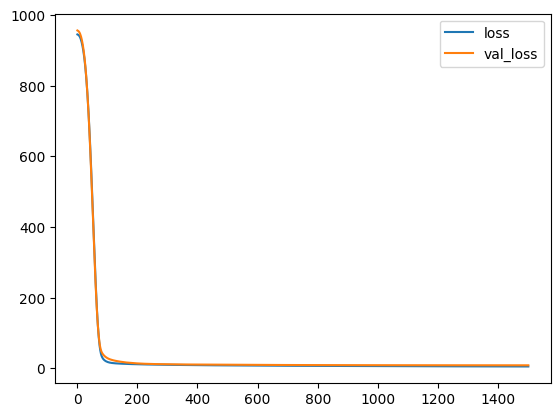

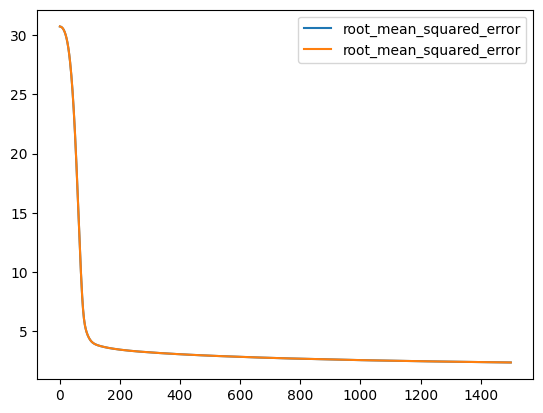

In [44]:
# Plot the mean squared error loss and root mean squared error
history_df.plot(y=["loss","val_loss"])
history_df.plot(y=["root_mean_squared_error","root_mean_squared_error"])

In [45]:
# Export model to HDF5 file
optimized_model.save("Obesity_Prediction_opt.h5")

In [46]:
# Load model
obesity_model = tf.keras.models.load_model("Obesity_Prediction_r2_832.h5")

In [47]:
# Import hypothetical data for 6 examples with different single variable changes to see the predictions (for fun!)
hypothetical_df = pd.read_csv("Hypothetical_Data.csv")
hypothetical_df

,YearStart,Percent of adults aged 18 years and older who have an overweight classification,Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination),Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic physical activity and engage in muscle-strengthening activities on 2 or more days a week,Percent of adults who achieve at least 300 minutes a week of moderate-intensity aerobic physical activity or 150 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination),Percent of adults who engage in muscle-strengthening activities on 2 or more days a week,Percent of adults who engage in no leisure-time physical activity,LocationDesc_Alabama,LocationDesc_Alaska,LocationDesc_Arizona,...,Stratification1_Hawaiian/Pacific Islander,Stratification1_High school graduate,Stratification1_Hispanic,"Stratification1_Less than $15,000",Stratification1_Less than high school,Stratification1_Male,Stratification1_Non-Hispanic Black,Stratification1_Non-Hispanic White,Stratification1_Other,Stratification1_Some college or technical school
0,2023,35,50,18,33,30,20,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,2023,35,50,18,33,30,20,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2023,35,50,18,33,30,50,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2023,35,50,18,33,30,10,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2023,35,50,18,33,30,20,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2023,35,50,18,33,30,20,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
# Scale the data
X_hyp_scaled = X_scaler.transform(hypothetical_df)
y_hyp = obesity_model.predict(X_hyp_scaled)

1/1 [==============================] - 0s 80ms/step


In [49]:
# Add column to the hypothetical data to show the predictions for each row of data
hypothetical_df["PREDICTION Percent of adults aged 18 years and older who have obesity"] = [y_hyp[x].item() for x in range(len(y_hyp))]
hypothetical_df

,YearStart,Percent of adults aged 18 years and older who have an overweight classification,Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination),Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic physical activity and engage in muscle-strengthening activities on 2 or more days a week,Percent of adults who achieve at least 300 minutes a week of moderate-intensity aerobic physical activity or 150 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination),Percent of adults who engage in muscle-strengthening activities on 2 or more days a week,Percent of adults who engage in no leisure-time physical activity,LocationDesc_Alabama,LocationDesc_Alaska,LocationDesc_Arizona,...,Stratification1_High school graduate,Stratification1_Hispanic,"Stratification1_Less than $15,000",Stratification1_Less than high school,Stratification1_Male,Stratification1_Non-Hispanic Black,Stratification1_Non-Hispanic White,Stratification1_Other,Stratification1_Some college or technical school,PREDICTION Percent of adults aged 18 years and older who have obesity
0,2023,35,50,18,33,30,20,0,0,0,...,0,0,1,0,0,0,0,0,0,32.527821
1,2023,35,50,18,33,30,20,0,0,0,...,0,0,0,0,0,0,0,0,0,34.673397
2,2023,35,50,18,33,30,50,0,0,0,...,0,0,0,0,0,0,0,0,0,43.619556
3,2023,35,50,18,33,30,10,0,0,0,...,0,0,0,0,0,0,0,0,0,37.797028
4,2023,35,50,18,33,30,20,0,0,0,...,0,0,0,0,0,0,0,0,0,19.357216
5,2023,35,50,18,33,30,20,0,0,0,...,0,0,0,0,0,0,0,0,0,38.927387


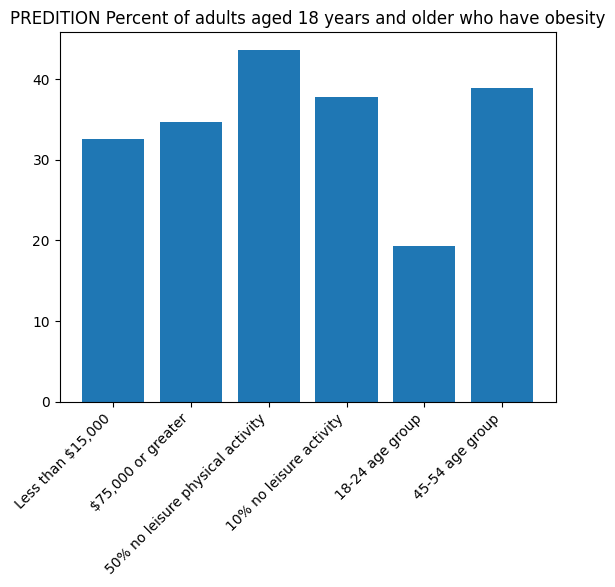

In [50]:
#compare the examples
from matplotlib import pyplot as plt
x_ticks = ["Less than $15,000", "$75,000 or greater", "50% no leisure physical activity", "10% no leisure activity", "18-24 age group", "45-54 age group"]
plt.bar(range(6), hypothetical_df["PREDICTION Percent of adults aged 18 years and older who have obesity"])
plt.xticks(ticks=range(6), rotation=45, labels=x_ticks, ha="right")
plt.title("PREDITION Percent of adults aged 18 years and older who have obesity")
plt.show()